# fly_2p analysis for EPG imaging

In [1]:
# confirm job id, to see you are on compute node
!echo $LSB_JOBID

147988435


In [2]:
from ScanImageTiffReader import ScanImageTiffReader
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari
import xarray as xr
import pandas as pd
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from shapely.geometry import Polygon

import napari, qtpy, superqt
print("napari:", napari.__version__)
print("qtpy:", qtpy.__version__)
print("superqt:", superqt.__version__)

napari: 0.6.4
qtpy: 2.4.3
superqt: 0.7.6


In [3]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [4]:
%gui qt
%config Completer.use_jedi = False  #magic to fix autocomplete issue

# viewer

QStandardPaths: error creating runtime directory '/run/user/65875' (Permission denied)
QStandardPaths: error creating runtime directory '/run/user/65875' (Permission denied)
Qt: Session management error: Could not open network socket


In [5]:
from fly2p.viz.viz import *
import fly2p.preproc.imgPreproc as imp
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict, loadvolume
onCluster = True

### data details

In [6]:
# === Set root storage directory depending on environment ===
storageDir = '/groups/otopalik' if onCluster else '/Volumes'
# rootDir = '/Volumes/otopaliklab/Temporary_Storage/Aisha/ImagingData'
# rootDir = 'C:\\Users\\hamida\\Documents\\Data'
rootDir = '/groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData'

In [7]:
flyID = 'Fly_0013'
trial_folder = 'E'


dataDir = sep.join([rootDir, 'raw', flyID, trial_folder])
preprocDir = sep.join([rootDir, 'preproc', flyID, trial_folder])
plotDir = sep.join([rootDir, 'plot',flyID, trial_folder])

# Create the directories if they don't exist
os.makedirs(dataDir, exist_ok=True)
os.makedirs(preprocDir, exist_ok=True)
os.makedirs(plotDir, exist_ok=True)


print(f'flyID: {flyID}, trial folder: {trial_folder}')
rawTiff = 'Fly_0013E_00001.tif'

flyID: Fly_0013, trial folder: E


In [8]:
tiff_path = sep.join([dataDir, rawTiff])
tiff_path

'/groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData/raw/Fly_0013/E/Fly_0013E_00001.tif'

In [9]:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))
basicMetadat = getSIbasicMetadata(mytiffreader.metadata())
basicMetadat["CaCh"] = 0 # give channel identity
SImetadict = getSIMetadict(mytiffreader.metadata())

SI.VERSION_COMMIT = 'b0e89ff7717e60826b56173afe65ddb1ea6efb87'
SI.VERSION_MAJOR = 2023
SI.VERSION_MINOR = 1
SI.VERSION_UPDATE = 0


In [194]:
basicMetadat

{'nCh': 1,
 'fpsscan': 157.3463846914556,
 'discardFBFrames': 'true',
 'nDiscardFBFrames': 4,
 'fpv': 12,
 'nVols': 3300,
 'stackZStepSize': 6.0,
 'scanVolumeRate': 13.11219872428796,
 'fovCoords': {'p00': [np.float64(-29.34782608695653),
   np.float64(-29.34782608695653)],
  'p10': [np.float64(29.34782608695653), np.float64(29.34782608695653)],
  'p01': [np.float64(29.34782608695653), np.float64(-29.34782608695653)],
  'p11': [np.float64(-29.34782608695653), np.float64(29.34782608695653)]},
 'xrange_um': np.float64(58.69565217391306),
 'yrange_um': np.float64(58.69565217391306),
 'CaCh': 0}

In [195]:
stack = loadvolume(tiff_path, basicMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, basicMetadat)

In [196]:
imgStack.shape

(3300, 8, 128, 128)

### motion correction


/tmp/ipykernel_1881436/923414729.py:11: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


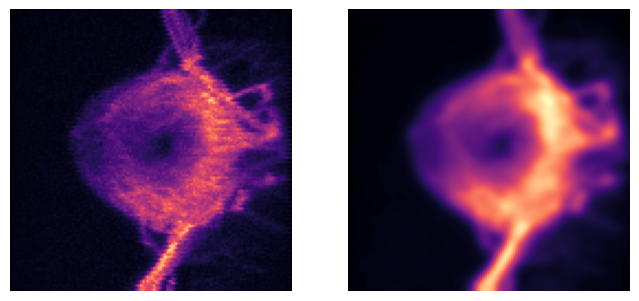

In [197]:
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over planes

numRefImg = 20
refstart = 110
locRefImg = round(stackMP['volumes [s]'].size/2)

# Generate reference image
refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0) + np.mean(stackMP[refstart:refstart+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='magma', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='magma', origin='lower'); axs[1].axis('off');
fig.savefig(preprocDir+sep+'referenceimageMIP.pdf')


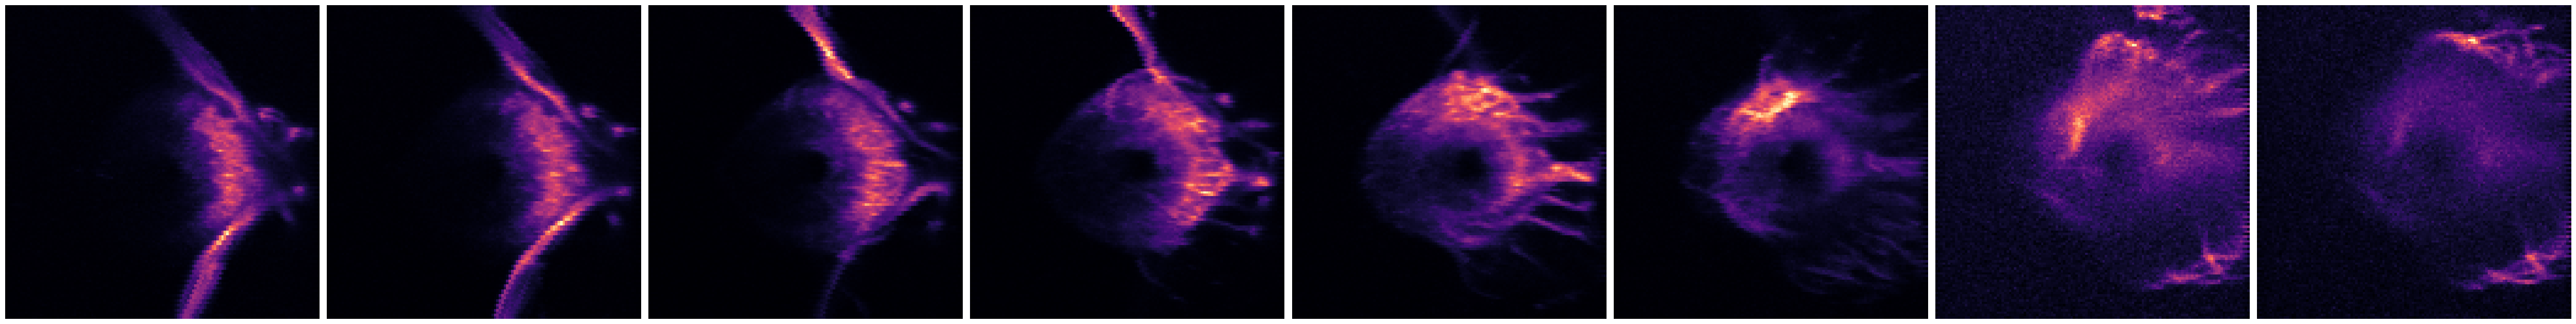

In [198]:
# Make reference volume
numRefImg = 110
refVol = np.mean(imgStack[round(imgStack['volumes [s]'].size/2) :round(imgStack['volumes [s]'].size/2) +numRefImg,:,:,:],axis=0) + \
    np.mean(imgStack[round(imgStack['volumes [s]'].size/6) :round(imgStack['volumes [s]'].size/4) +numRefImg,:,:,:],axis=0)

# uncomment to check reference volume in napari
#viewerRefVol = napari.view_image(refVol, contrast_limits=[refVol.data.min(),np.percentile(refVol, 99.9)])

nplanes = refVol.data.shape[0]

fig, axs = plt.subplots(1,nplanes, figsize=(50,8))
for p in range(nplanes):
    axs[p].imshow(refVol.data[p,:,:], cmap='magma')
    axs[p].axis('off')
fig.tight_layout()
fig.savefig(preprocDir+sep+'referenceimage_slices.pdf')

In [199]:
stackMP.shape

(3300, 128, 128)

In [ ]:
# stackMP_fraction = stackMP[:6000]
# stackMP_fraction.shape
# stackMP2 = stackMP_fraction
# # and replace stackMP2 with stackMP in the cells below if you only want a fraction

perform motion correction on a single plane/max projection
. . . . . . . . . . . . . . . . . . . . 

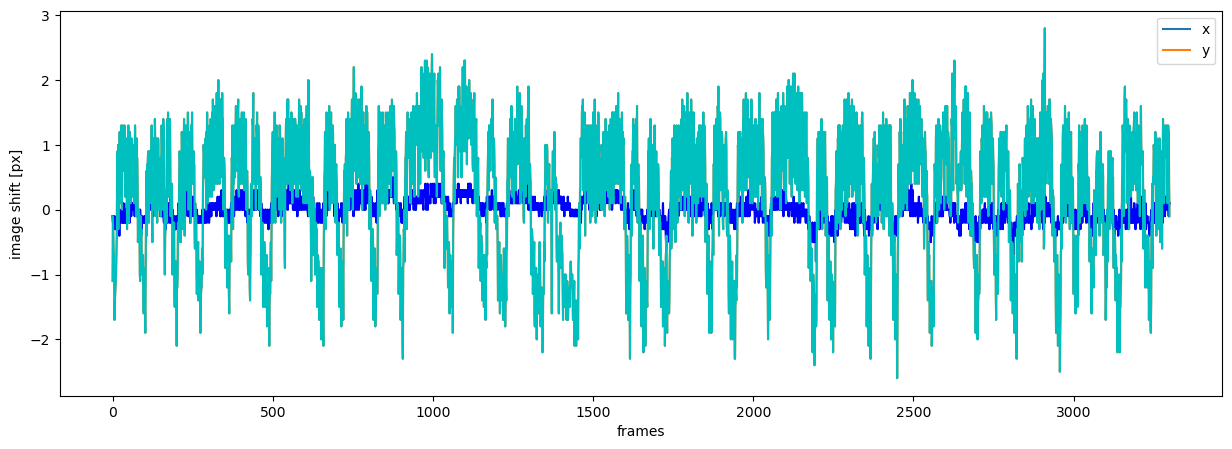

In [200]:
# If there are unreasonable shifts select "doFilter=True".
shift = imp.computeMotionShift(stackMP, refImg, 10, 2, doFilter=True, stdFactor=4, showShiftFig=True)
stackMPMC = imp.motionCorrection(stackMP, shift)

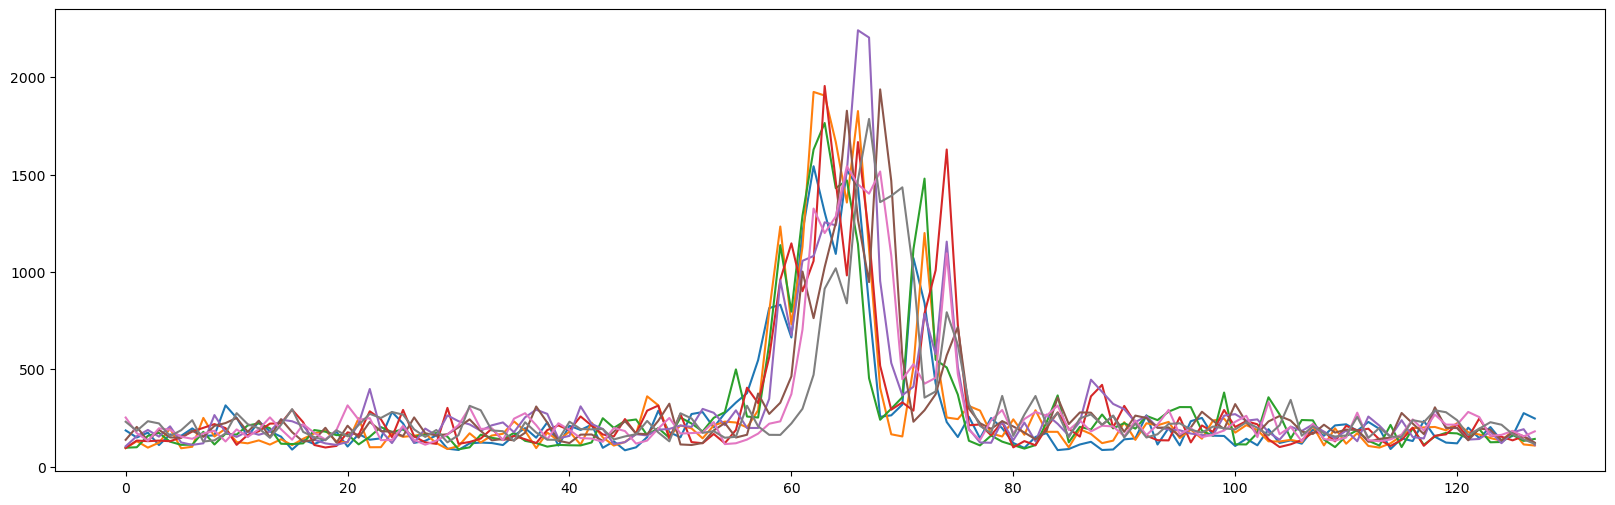

In [201]:
fig, axs = plt.subplots(1,1,figsize=(20,6))
for p in range(nplanes):
    axs.plot(p*5+np.hypot(stackMPMC[0,p,:],stackMPMC[1,p,:]))

In [202]:
# To visualize all your volumes
viewer = napari.view_image(stackMPMC)
viewer.window._qt_window.raise_()
viewer.window._qt_window.activateWindow()
viewer.window._qt_window.show()

/tmp/ipykernel_1881436/184108534.py:2: FutureWarning: `napari.view_image` is deprecated and will be removed in napari 0.7.0.
Use `viewer = napari.Viewer(); viewer.add_image(...)` instead.
  viewer = napari.view_image(stackMPMC)


In [203]:
viewer.close()

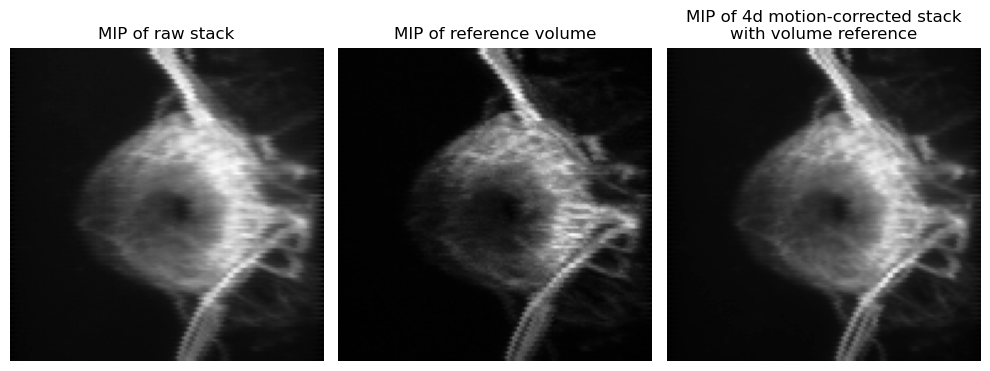

In [204]:
fig, axs = plt.subplots(1,3,figsize=(10,4))
cb = axs[0].imshow(np.mean(stackMP,axis=0),cmap='Greys_r', origin='upper')
axs[0].set_title('MIP of raw stack')
axs[0].axis('off');
cb = axs[1].imshow(refVol.max(axis=0),cmap='Greys_r', origin='upper')
axs[1].set_title('MIP of reference volume')
axs[1].axis('off');
cb = axs[2].imshow(stackMPMC.mean(axis=0),cmap='Greys_r', origin='upper')
axs[2].set_title('MIP of 4d motion-corrected stack\nwith volume reference')
axs[2].axis('off');
fig.tight_layout()
fig.savefig(preprocDir+sep+'beforeAfterMotionCorrection_MIP_4d.pdf')


Variance map saved to: /groups/otopalik/otopaliklab/Temporary_Storage/Aisha/ImagingData/preproc/Fly_EB_0008/F/temporal_variance_map.pdf


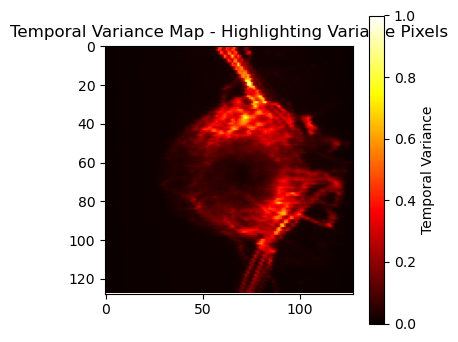

In [205]:
# see variance to choose regions of interest:

var_image = stackMPMC.var(dim='volumes [s]')  # variance across time
var_np = var_image.values

# Normalize for display
var_norm = (var_np - var_np.min()) / (var_np.max() - var_np.min() + 1e-8)

plt.figure(figsize=(4, 4))
plt.imshow(var_norm, cmap='hot')
plt.colorbar(label='Temporal Variance')
plt.title('Temporal Variance Map - Highlighting Variable Pixels')

# Save before showing
save_path = os.path.join(preprocDir, 'temporal_variance_map.pdf')
plt.savefig(save_path, bbox_inches='tight', dpi=300)
print(f"Variance map saved to: {save_path}")

plt.show()


In [206]:
# settings for Savitzky-Golay filter (default: 3rd order, 7 frames)
order = 3
window = 7

# Currently F_0 is estimated for each pixel on the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

# Compute DFF
dffStack4d, stackF0vol = imp.computeDFF(stackMPMC, order, window, baseLinePercent, offset,baselineLowestMean=True)

processing 3d stack


In [207]:
# ------------------------------------------
# defining background in napari
# ------------------------------------------

# draw a mask on the foreground
viewer = napari.view_image(stackMPMC.mean(axis=0), contrast_limits=[stackMPMC.data.mean(axis=0).min(),np.percentile(stackMPMC.mean(axis=0), 99.9)])
if exists(sep.join([preprocDir,'background_3d.npy'])):
    background = np.load(sep.join([preprocDir,'background_3d.npy'])) 
    viewer.add_labels(background, name='background')

/tmp/ipykernel_1881436/395199942.py:6: FutureWarning: `napari.view_image` is deprecated and will be removed in napari 0.7.0.
Use `viewer = napari.Viewer(); viewer.add_image(...)` instead.
  viewer = napari.view_image(stackMPMC.mean(axis=0), contrast_limits=[stackMPMC.data.mean(axis=0).min(),np.percentile(stackMPMC.mean(axis=0), 99.9)])


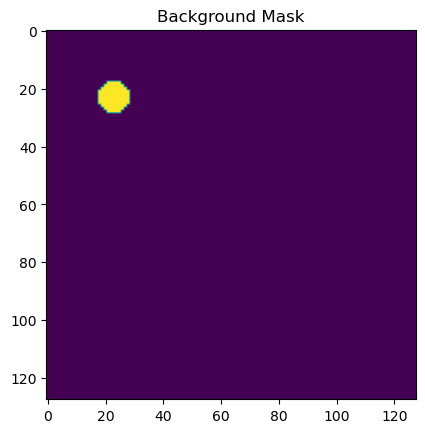

In [208]:
background = viewer.layers["background"].data

if not exists(preprocDir): makedirs(sep.join([preprocDir]))
np.save(sep.join([preprocDir,'background_3d']), background)
viewer.close()

plt.imshow(background);
plt.title("Background Mask");

In [209]:
dffStack, stackF0 = imp.computeDFF(stackMPMC, order, window, baseLinePercent, offset)
dffXarray = imp.stack2xarray(dffStack, basicMetadat, data4D = False)
F0Xarray = imp.refStack2xarray(stackF0, basicMetadat, data4D = False)

processing 3d stack


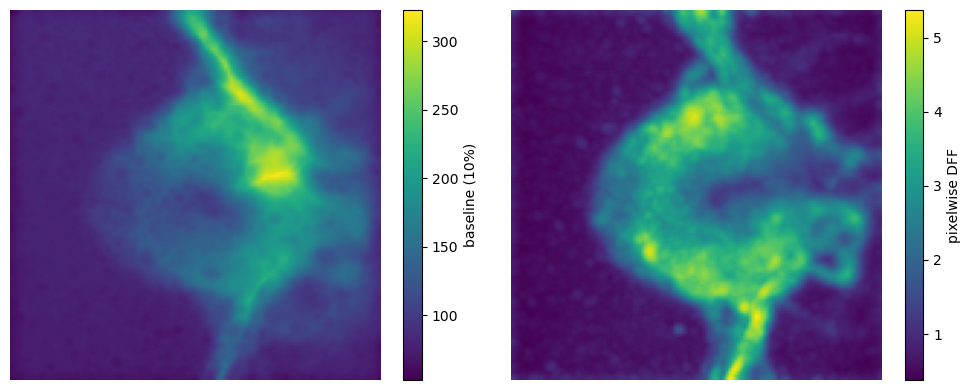

In [210]:
dffMP = np.max(dffStack,axis=0)
fig, ax = plt.subplots(1,2,figsize=(10,4))
cb = ax[0].imshow(stackF0,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[0], label='baseline ({}%)'.format(baseLinePercent))
ax[0].axis('off')
cb = ax[1].imshow(dffMP,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[1], label='pixelwise DFF')
ax[1].axis('off')
fig.tight_layout()

# viewerdff = napari.view_image(dffMP)
fig.savefig(preprocDir+sep+'BaselineAndDFF_MIP_3d.pdf')


In [211]:
# -----------------------------------------------------------
# defining rois in napari for EB, split into 16 or 32 wedges
# -----------------------------------------------------------

# you can draw a mask to constraint which pixels will be included in corrleation analysis
viewer = napari.view_image(dffMP)
if exists(sep.join([preprocDir,'EBctr.npy'])):
    ebcenter = np.load(sep.join([preprocDir,'EBctr.npy'])) #centre dots tool
    eblongax = np.load(sep.join([preprocDir,'EBlax.npy']))  # large axis
    ebshortax = np.load(sep.join([preprocDir,'EBsax.npy'])) # short axis
    viewer.add_points(ebcenter, size = 5, name='EBctr')
    viewer.add_shapes(eblongax, name='EBlax',shape_type='line', edge_color = 'cyan')
    viewer.add_shapes(ebshortax, name='EBsax',shape_type='line', edge_color = 'blue')

/tmp/ipykernel_1881436/1846691187.py:6: FutureWarning: `napari.view_image` is deprecated and will be removed in napari 0.7.0.
Use `viewer = napari.Viewer(); viewer.add_image(...)` instead.
  viewer = napari.view_image(dffMP)


In [212]:
ebcenter = viewer.layers["EBctr"].data[0]
eblongax = viewer.layers["EBlax"].data[0]
ebshortax = viewer.layers["EBsax"].data[0]
if not exists(sep.join([preprocDir])): makedirs(sep.join([preprocDir]))
np.save(sep.join([preprocDir,'EBctr']), ebcenter)
np.save(sep.join([preprocDir,'EBlax']), eblongax)
np.save(sep.join([preprocDir,'EBsax']), ebshortax)
viewer.close()

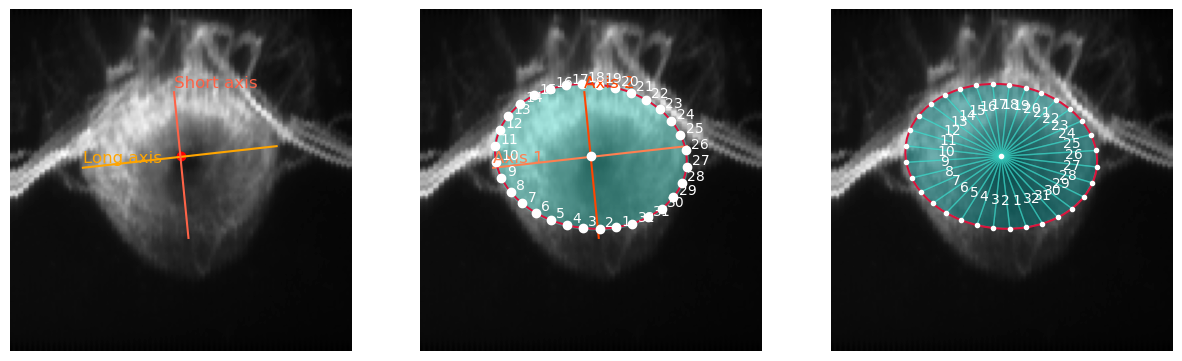

In [213]:
EBslices = 32
startLoc = 5 # this is one of the EB wedges to have the bpttom as 0 degree

EBaxisL, EBaxisS, ellipseRot, ebcenter, EBoutline = generateEBellipse(eblongax,ebshortax,ebcenter,printResults = False)
EBroiPts, EBroiPolys = constructEBROIs(ebcenter, EBoutline, nsteps=EBslices, st=startLoc)

refEBimg = np.mean(stackMPMC,axis=0).T
fig = plotEBshapelyROIs(refEBimg, ebcenter, EBaxisL, EBaxisS, ellipseRot, EBoutline, EBroiPts, EBroiPolys)
fig.savefig(plotDir+sep+'_'.join(['polyRoiConstruction', flyID, trial_folder])+'.pdf')

In [ ]:
dffROI = getDFFfromEllipseROI(EBroiPts,EBroiPolys,dffXarray)
time = dffXarray.coords['volumes [s]'].values

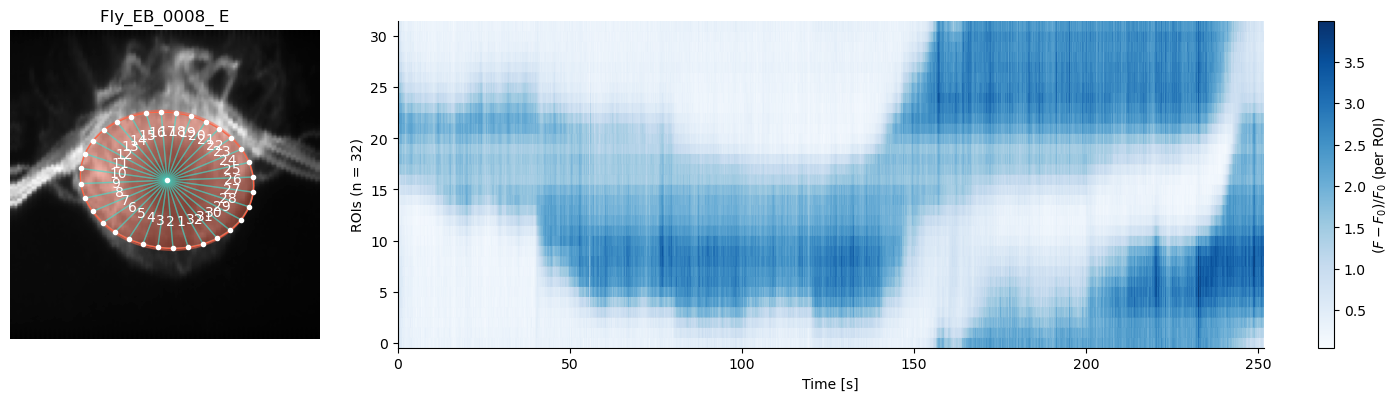

In [177]:
fig, axs = plt.subplots(1,2, figsize=(15,4),gridspec_kw={'width_ratios':[1,3.5]})
axs[0].imshow(np.mean(stackMPMC,axis=0).T,cmap='Greys_r', origin='lower')#, vmin=0, vmax=0.7*np.max(stackMP))

patch = ppatch.Ellipse(ebcenter, EBaxisL.length, EBaxisS.length, angle=-ellipseRot, alpha = 0.4, color='tomato')

axs[0].add_patch(patch)
axs[0].plot(EBoutline.coords.xy[0],EBoutline.coords.xy[1], color='tomato', linewidth=1)

for s in range(len(EBroiPts)-1):
    roiPatch = ppatch.Polygon(EBroiPolys[s],alpha=0.4, edgecolor='turquoise', facecolor='none')
    axs[0].add_patch(roiPatch)
    axs[0].plot(EBroiPts[s+1][0],EBroiPts[s+1][1], 'w.')
    labcoord = Polygon(EBroiPolys[s]).centroid.coords.xy
    axs[0].text(labcoord[0][0],labcoord[1][0], str(s+1), color='w')

axs[0].plot(EBroiPts[0][0],EBroiPts[0][1], 'w.')
axs[0].axis('off')
axs[0].set_title('_ '.join([flyID, trial_folder]))

axs[1] = plotDFFheatmap(time, dffROI, axs[1], fig) #vmax=1.5)
myAxisTheme(axs[1])

fig.tight_layout()
fig.savefig(plotDir+sep+'_'.join(['roiMap-dFFtimeseries', flyID, trial_folder])+'.pdf')


#### generate data object for roiDf and save

In [178]:
roiDf = pd.DataFrame(data = dffROI.T, columns = ['slice{}'.format(i+1) for i in range(len(EBroiPts)-1)])
roiDf['time [s]'] = time
roiDf.head()

,slice1,slice2,slice3,slice4,slice5,slice6,slice7,slice8,slice9,slice10,...,slice24,slice25,slice26,slice27,slice28,slice29,slice30,slice31,slice32,time [s]
0,0.394184,0.445970,0.391456,0.337036,0.456197,0.459033,0.441377,0.311671,0.341648,0.294555,...,1.966898,1.656419,1.321734,1.252144,1.041071,0.853694,0.756540,0.661843,0.480444,0.000000
1,0.482094,0.545866,0.439631,0.451007,0.468524,0.462385,0.469593,0.411217,0.312801,0.235272,...,1.866989,1.722734,1.645507,1.156262,1.010927,0.863812,0.678856,0.523535,0.470139,0.076264
2,0.609425,0.569705,0.484692,0.468243,0.465498,0.519418,0.524285,0.421201,0.383210,0.307024,...,1.916623,1.716279,1.490502,1.196013,0.987830,0.814745,0.680380,0.548607,0.520603,0.152528
3,0.605632,0.553660,0.527333,0.569074,0.594068,0.640599,0.610847,0.498701,0.513526,0.453056,...,1.958416,1.796593,1.564891,1.253557,1.064433,0.776169,0.665925,0.614909,0.556136,0.228792
4,0.562381,0.543521,0.550184,0.635733,0.665711,0.673621,0.603364,0.564069,0.601597,0.530777,...,1.997821,1.846388,1.614088,1.273875,1.065662,0.828695,0.702648,0.632750,0.582983,0.305055


In [179]:
csv_path = preprocDir + sep + '_'.join(['roiDFF', flyID, trial_folder]) + '.csv'
roiDf.to_csv(csv_path, index=False)

In [180]:
dffROI.shape

(32, 3300)

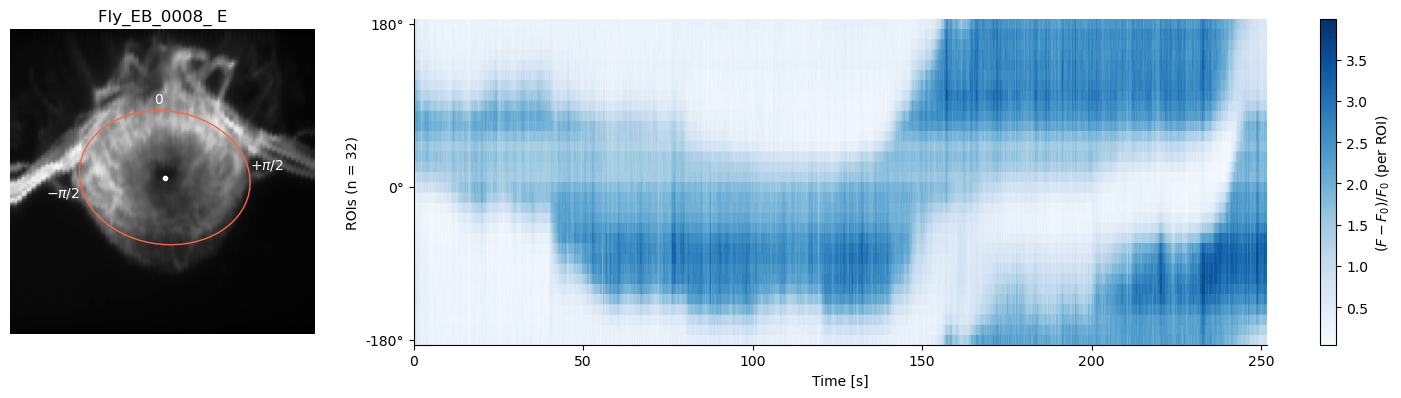

In [181]:
fig, axs = plt.subplots(1,2, figsize=(15,4),gridspec_kw={'width_ratios':[1,3.5]})
axs[0].imshow(np.mean(stackMPMC,axis=0).T,cmap='Greys_r', origin='lower')#, vmin=0, vmax=0.7*np.max(stackMP))

patch = ppatch.Ellipse(ebcenter, EBaxisL.length, EBaxisS.length, angle=-ellipseRot, alpha = 0.4, color='tomato')

# axs[0].add_patch(patch)
axs[0].plot(EBoutline.coords.xy[0],EBoutline.coords.xy[1], color='tomato', linewidth=1)

# for s in range(len(EBroiPts)-1):
#     roiPatch = ppatch.Polygon(EBroiPolys[s],alpha=0.4, edgecolor='turquoise', facecolor='none')
#     axs[0].add_patch(roiPatch)
#     axs[0].plot(EBroiPts[s+1][0],EBroiPts[s+1][1], 'w.')
#     labcoord = Polygon(EBroiPolys[s]).centroid.coords.xy
#     axs[0].text(labcoord[0][0],labcoord[1][0], str(s+1), color='w')

axs[0].plot(EBroiPts[0][0],EBroiPts[0][1], 'w.')
axs[0].axis('off')
axs[0].set_title('_ '.join([flyID, trial_folder]))

##################
# check for adding labels for 0 degree on the short axis

# Get direction vector of short axis (from coords[0] to coords[1])
dx = EBaxisS.coords[1][0] - EBaxisS.coords[0][0]
dy = EBaxisS.coords[1][1] - EBaxisS.coords[0][1]

# Normalize direction
length = np.hypot(dx, dy)
ux, uy = dx / length, dy / length

# Go from coords[0] (the correct tip), in *opposite* direction of vector (i.e., toward 0°)
offset = 0.1 * length
label_x = EBaxisS.coords[0][0] - offset * ux
label_y = EBaxisS.coords[0][1] - offset * uy

# Add label '0' slightly beyond the start of short axis
axs[0].text(label_x, label_y, '0', color='white', ha='center', va='center', fontsize=10)


# check for adding labels for +pi/2 and -pi/2  degree on the long axis

# === Add '-π/2' and '+π/2' labels at the ends of the long axis ===

# Get direction vector of long axis (from coords[0] to coords[1])
dxL = EBaxisL.coords[1][0] - EBaxisL.coords[0][0]
dyL = EBaxisL.coords[1][1] - EBaxisL.coords[0][1]

# Normalize
lengthL = np.hypot(dxL, dyL)
uxL, uyL = dxL / lengthL, dyL / lengthL

# Offset scale (e.g., 10% of the axis length)
offsetL = 0.1 * lengthL

# === Label on the start of the long axis ('-π/2') ===
labelL1_x = EBaxisL.coords[0][0] - offsetL * uxL
labelL1_y = EBaxisL.coords[0][1] - offsetL * uyL
axs[0].text(labelL1_x, labelL1_y, r'$-\pi/2$', color='white', ha='center', va='center', fontsize=10)

# === Label on the end of the long axis ('+π/2') ===
labelL2_x = EBaxisL.coords[1][0] + offsetL * uxL
labelL2_y = EBaxisL.coords[1][1] + offsetL * uyL
axs[0].text(labelL2_x, labelL2_y, r'$+\pi/2$', color='white', ha='center', va='center', fontsize=10)


###################
axs[1] = plotDFFheatmap(time, dffROI, axs[1], fig) #vmax=1.5
# ROI 15 (bottom) → 0°, ROI 0 → -180°, ROI 31 → +180°
angle_labels = []
for i in range(32):
    angle = ((i - 15) * 360 / 32)  # 360° circle divided into 32 ROIs, 0 at ROI 15
    # Wrap around to keep angles between -180 and +180
    if angle > 180:
        angle -= 360
    angle_labels.append(f"{int(angle)}°")

myAxisTheme(axs[1])
# axs[1].set_yticks(np.arange(32))
# axs[1].set_yticklabels(angle_labels)

axs[1].set_yticks([0, 15, 31])
axs[1].set_yticklabels(['-180°', '0°', '180°'])

fig.tight_layout()
fig.savefig(plotDir+sep+'_'.join(['roiMap-dFFtimeseries_180to-180', flyID, trial_folder])+'.pdf')


In [182]:
dffROI.shape

(32, 3300)

In [183]:
dffROI

array([[0.39418399, 0.4820942 , 0.60942531, ..., 0.88203502, 0.87515408,
        0.70495933],
       [0.44597045, 0.54586601, 0.56970471, ..., 1.26058495, 1.23720121,
        1.25505328],
       [0.39145595, 0.4396309 , 0.48469183, ..., 1.60419583, 1.86336172,
        1.63073254],
       ...,
       [0.75654042, 0.67885596, 0.68038023, ..., 0.51216388, 0.57489204,
        0.59797204],
       [0.66184306, 0.52353501, 0.54860735, ..., 0.59336948, 0.69211847,
        0.68367714],
       [0.48044363, 0.47013912, 0.52060264, ..., 0.64387023, 0.69271433,
        0.54074043]], shape=(32, 3300))



#### Plotting PVA on top of the heatmap


In [184]:
# Compute angles in radians from -π to +π
roi_indices = np.arange(32)
angles_deg = (roi_indices - 15) * 360 / 32  # ROI 15 = 0°, range: -180° to +180°
angles_rad = np.deg2rad(angles_deg)  # Convert to radians

# Compute population vector (circular mean) for each time point
# dffROI: shape (32, volumes)
x_components = np.sum(dffROI * np.cos(angles_rad[:, np.newaxis]), axis=0)
y_components = np.sum(dffROI * np.sin(angles_rad[:, np.newaxis]), axis=0)

# Compute circular mean angle and amplitude
mean_angles_rad = np.arctan2(y_components, x_components)  # shape: (N_time,)
amplitudes = np.sqrt(x_components**2 + y_components**2)   # shape: (N_time,)

# Convert mean angles to degrees (for plotting)
mean_angles_deg = np.rad2deg(mean_angles_rad)

# Optional: wrap to [-180, 180]
# mean_angles_deg = (mean_angles_deg + 180) % 360 - 180


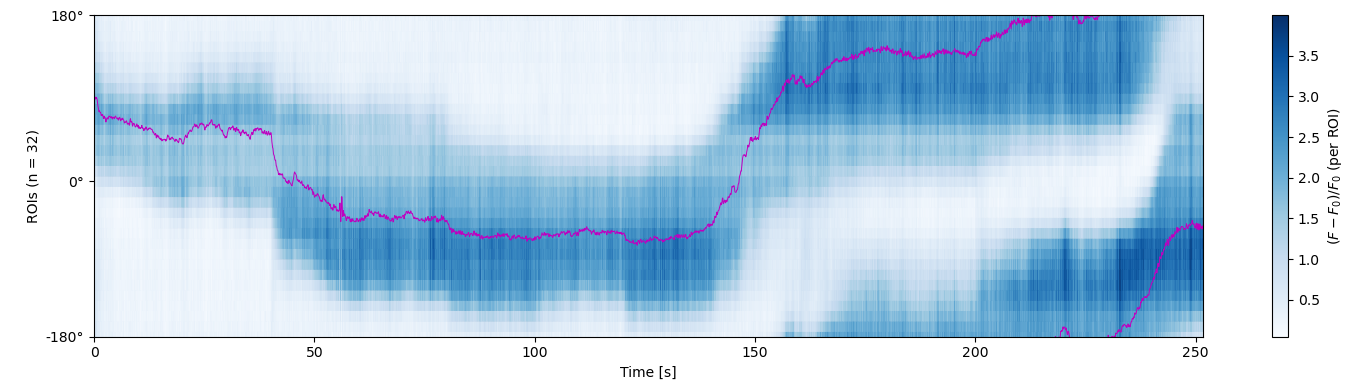

In [185]:
fig, ax = plt.subplots(figsize=(15, 4))

# Plot heatmap
ax = plotDFFheatmap(time, dffROI, ax, fig)

# Lock Y limits to heatmap extent
ax.set_ylim(0, 31)
# ax.set_xlim(0, 10)

# Y ticks
ax.set_yticks([0, 15, 31])
ax.set_yticklabels(['-180°', '0°', '180°'])

# Convert circular mean angle (degrees) to Y-axis positions
mean_y = (mean_angles_deg + 180) / 360 * 32

# ---- FIX CIRCULAR WRAP ----
angle_jump = np.abs(np.diff(mean_angles_deg)) > 180
mean_y_plot = mean_y.copy()
mean_y_plot[1:][angle_jump] = np.nan  # break the line at wrap points

# Overlay circular mean line
# ax.plot(time, mean_y_plot, linewidth=0.7, color='m')
ax.plot(time, (mean_y_plot % 32) - 0.5, linewidth=0.7, color='m')

# Save and show
fig.tight_layout()
fig.savefig(
    plotDir + sep + '_'.join(['roiMap-dFFtimeseries_with_circMean', flyID, trial_folder]) + '.pdf'
)
plt.show()


#Save the PVA amplitude and position as a dataframe


In [187]:
# Save DataFrame
results_df = pd.DataFrame({
    'time': time,
    'Bump position': mean_angles_deg,
    'Population vector average': amplitudes
})
# Save to CSV
results_df.to_csv(preprocDir + sep + '_'.join(['population_vector_summary', flyID, trial_folder]) + '.csv', index=False)

In [188]:
results_df

,time,Bump position,Population vector average
0,0.000000,88.253128,11.631840
1,0.076264,85.718038,11.832281
2,0.152528,85.263736,11.173687
3,0.228792,84.053639,11.019727
4,0.305055,83.542484,10.843971
...,...,...,...
3295,251.289333,-55.433960,19.444542
3296,251.365597,-54.679931,18.065586
3297,251.441861,-57.413688,18.220353
3298,251.518125,-56.111727,20.413599
